# Computational modeling : RL algorithms in a virtual environment

Question : under very low amounts of evidence, how do human sample a complex action space ? Can we infer some form of structure in this exploration ? Can Active Inference provide some answers regarding the mechanistic processes behind it ?



First, we grab the data corresponding to the experiment we're interested in (here, experiment 002). We also remove the subjects that either had technical issues or had very suspicious results. *(we should provide a clear rule on subject exclusion here, maybe based on action variance across all dimensions or reaction times ?).*

In [1]:
# Import the needed packages 
# 
# 1/ the usual suspects
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import vmap

from functools import partial

# 2/ The Active Inference package 
import actynf
from actynf.jaxtynf.jax_toolbox import _normalize,_jaxlog

# 3/ Tools for : 
# a. Getting the raw data : 
from database_handling.database_extract import get_all_subject_data_from_internal_task_id
from utils import remove_by_indices
# b. Preprocessing the data :
from analysis_tools.preprocess import OPTIONS_PREPROCESS_DEFAULT,get_preprocessed_data



# We define the environment as a state machine that outputs a feedback 
# every time an action is given to it : 
from actynf.jaxtynf.layer_process import initial_state_and_obs,process_update
from actynf.jaxtynf.shape_tools import vectorize_weights


# The environment is statically defined by its HMM matrices : 
from hmm_weights import behavioural_process

# For the active inference model : 
from hmm_weights import basic_latent_model

from actynf.jaxtynf.layer_trial import compute_step_posteriors
from actynf.jaxtynf.layer_learn import learn_after_trial
from actynf.jaxtynf.layer_options import get_learning_options,get_planning_options

from actynf.jaxtynf.shape_tools import to_log_space,get_vectorized_novelty




c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# To generate synthetic data :
from simulate.generate_observations import TrainingEnvironment,run_loop,generate_synthetic_data

T = 11

# ENVIRONMENTAL CONSTANTS :
N_FEEDBACK_OUTCOMES = 10
TRUE_FEEDBACK_STD = 0.15
GRID_SIZE = (7,7)
START_COORD = [[5,1],[5,2],[4,1]]
END_COORD = [0,6]

# The weights of the HMM environment
(a,b,c,d,e,u),fb_vals = behavioural_process(GRID_SIZE,START_COORD,END_COORD,N_FEEDBACK_OUTCOMES,TRUE_FEEDBACK_STD)

rngkey = jax.random.PRNGKey(np.random.randint(0,10))
env = TrainingEnvironment(rngkey,a,b,c,d,e,u,T)
    
for k in range(10):
    print("----Trial {}----".format(k))
    o,r,end_trial,t = env.reinit_trial()
    print(t,o,r)
    while not(end_trial) :
        action = jax.nn.one_hot(1,9)
        o,r,end_trial,t = env.step(action)
        print(t,o,r)
    print("----")
        

----Trial 0----
0 [Array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)] 0.0
1 [Array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)] -0.22222221
2 [Array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)] 0.0
3 [Array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)] -0.111111134
4 [Array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)] -0.33333334
5 [Array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)] 0.44444448
6 [Array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)] 0.111111104
7 [Array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)] -0.33333334
8 [Array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)] 0.0
9 [Array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)] -0.11111112
10 [Array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)] 0.11111112
----
----Trial 1----
0 [Array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)] 0.0
1 [Array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0

To put all the models we are going to fit in an equal footing, we will assume a discretized action space along the 3 dimensions previously mentionned for all of them. To study the effect of not making this crucial hypothesis, we refer the reader to the Reinforcment Learning part of this study. 

Reward definition : we will assume that agents perceive changes in the level of the gauge as a reward signal.

Here, we will study the following models : 
### Blind models - the action does not depend on the stimuli at all
1. A random action model that selects actions randomly and does not learn
2. A choice kernel model that repeats actions it already performed :  $CK_{t+1}(u) = CK_{t}(u) + \alpha_c (a_t - CK_{t}(u))$ where $a_t$ is 1 if $u$ was selcted and 0.0 otherwise. $P_t(u) = \sigma(\beta_c CK_{t})$
### Stateless models - the action does not depend on the level of the gauge but only on the reward
3. A Rescorla-Wagner model - stateless that attempts to learn the value of a specific action by updating the perceived reward attached to it : $Q_{t+1}(u) = Q_{t}(u) + \alpha (r_t - Q_{t}(u))$  (Wilson RC, Collins AG. Ten simple rules for the computational modeling of behavioral data. Elife. 2019 Nov 26;8:e49547. doi: 10.7554/eLife.49547. PMID: 31769410; PMCID: PMC6879303.). Actions are selected through a tempered softmax following : $P_t(u) = \sigma(\beta Q_{t})$. The free parameters for this model are $\alpha$ and $\beta$.
4. A mix of the previous 2 models : $P_t(u) = \sigma(\beta Q_{t} + \beta_c CK_{t})$
### Stateful models - the action depends on the level of the gauge as well as the reward
5. A tabular Q-learning agent : $Q_{t+1}(u,s) = Q_{t}(u,s) + \alpha (r_t - Q_{t}(u,s))$ with different learning rates for positive and negative feedbacks $\{\alpha_-,\alpha_+\}$ with a choice temperature $\beta$.
6. A vesion of this agent that takes into account the choice Kernel described previously
### Bayesian Active Inference models - The reward is not taken into account. The level of the gauge is interpreted as an indicator regarding a true (hidden) state of the system
7. A single dimension model ("How far am I from my goal ?") with various subcategories of models : 
    - A naive q learning like model  with low amounts of states
    - A more advanced model that features the ability to generalize between states
    - An even more advanced model that also features the ability to generalize between actions
8. A bidimensionnal model ("Where am I in the grid ? Where is my goal ?")




Because we have a much more complex intuition behind what is happening but with a pretty hard-to-derive likelihood function, we should look at Simulation Based Inference (see https://elifesciences.org/articles/56261#s4,https://astroautomata.com/blog/simulation-based-inference/,Artificial neural networks for model identification and parameter estimation in computational cognitive models, Milena Rmus ,Ti-Fen Pan,Liyu Xia,Anne G. E. Collins, Published: May 15, 2024; https://doi.org/10.1371/journal.pcbi.1012119 )

Are there any difference between the two ?

In [3]:
from agents import random_agent

# In : an agent based on some hyperparameters : 
SEED = 100
NTRIALS = 10
random_agent_hyperparameters = None
random_agent_constants = (9,)

params_final,training_hist = run_loop(env,random_agent(random_agent_hyperparameters,random_agent_constants),SEED,NTRIALS)
print(jnp.array(training_hist["actions"]).shape)

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
(10, 10, 9)


In [4]:
from agents import choice_kernel_agent

ck_agent_hyperparameters = (0.5,1.0)
ck_agent_constants = (9,)

params_final,training_hist = run_loop(env,choice_kernel_agent(ck_agent_hyperparameters,ck_agent_constants),SEED,NTRIALS)


Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


In [5]:
from agents import rescorla_wagner_agent

rw_agent_hyperparameters = (0.5,1.0)
rw_agent_constants = (9,)

params_final,training_hist = run_loop(env,rescorla_wagner_agent(rw_agent_hyperparameters,rw_agent_constants),SEED,NTRIALS)

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


In [6]:
from agents import rw_ck_agent

rw_ck_agent_hyperparameters = (0.1,0.5,0.5,0.1)
rw_ck_agent_constants = (9,)

params_final,training_hist = run_loop(env,rw_ck_agent(rw_ck_agent_hyperparameters,rw_ck_agent_constants),SEED,NTRIALS)

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


In [7]:
from agents import q_learning_agent

ql_ck_agent_hyperparameters = (0.5,0.7,1.0,0.0,0.0)
ql_ck_agent_constants = (9,N_FEEDBACK_OUTCOMES)

params_final,training_hist = run_loop(env,q_learning_agent(ql_ck_agent_hyperparameters,ql_ck_agent_constants),SEED,NTRIALS)

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


Trial 0
(10,)
(10, 5)
(11, 5)
Trial 1
(10,)
(10, 5)
(11, 5)
Trial 2
(10,)
(10, 5)
(11, 5)
Trial 3
(10,)
(10, 5)
(11, 5)
Trial 4
(10,)
(10, 5)
(11, 5)
Trial 5
(10,)
(10, 5)
(11, 5)
Trial 6
(10,)
(10, 5)
(11, 5)
Trial 7
(10,)
(10, 5)
(11, 5)
Trial 8
(10,)
(10, 5)
(11, 5)
Trial 9
(10,)
(10, 5)
(11, 5)
Trial 10
(10,)
(10, 5)
(11, 5)
Trial 11
(10,)
(10, 5)
(11, 5)
Trial 12
(10,)
(10, 5)
(11, 5)
Trial 13
(10,)
(10, 5)
(11, 5)
Trial 14
(10,)
(10, 5)
(11, 5)
Trial 15
(10,)
(10, 5)
(11, 5)
Trial 16
(10,)
(10, 5)
(11, 5)
Trial 17
(10,)
(10, 5)
(11, 5)
Trial 18
(10,)
(10, 5)
(11, 5)
Trial 19
(10,)
(10, 5)
(11, 5)
Trial 20
(10,)
(10, 5)
(11, 5)
Trial 21
(10,)
(10, 5)
(11, 5)
Trial 22
(10,)
(10, 5)
(11, 5)
Trial 23
(10,)
(10, 5)
(11, 5)
Trial 24
(10,)
(10, 5)
(11, 5)
Trial 25
(10,)
(10, 5)
(11, 5)
Trial 26
(10,)
(10, 5)
(11, 5)
Trial 27
(10,)
(10, 5)
(11, 5)
Trial 28
(10,)
(10, 5)
(11, 5)
Trial 29
(10,)
(10, 5)
(11, 5)
Trial 30
(10,)
(10, 5)
(11, 5)
Trial 31
(10,)
(10, 5)
(11, 5)
Trial 32
(10,)
(10

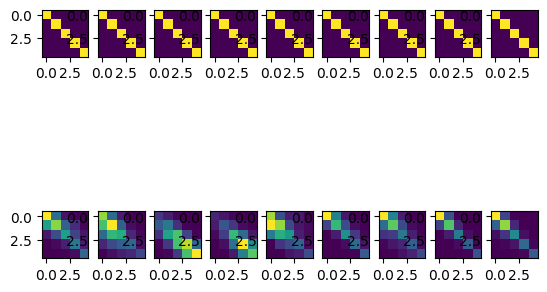

In [9]:
from agents import active_inference_basic_1D

# We get a model weights by defining a "parameters" object :
aif_1d_constants = {
    # General environment : 
    "N_feedback_ticks":N_FEEDBACK_OUTCOMES,
    # Latent state space structure
    "Ns_latent":5,      # For 1D
    # Action discretization:
    "N_actions_distance" :3,
    "N_actions_position" :9,
    "N_actions_angle" :9,
    
    "Th" : 3
}

aif_1d_params = {    
    # ----------------------------------------------------------------------------------------------------
    # Model parameters : these should interact with the model components in a differentiable manner
    "transition_concentration": 1.0,
    "transition_stickiness": 1.0,
    "transition_learning_rate" : 1.0,
    "state_interpolation_temperature" : 1.0,
    
    "initial_state_concentration": 1.0,
    
    "feedback_expected_std" : 0.15,
    "emission_concentration" : 1.0,
    "emission_stickiness" : 100.0,
    
    "reward_seeking" : 10.0,
    
    "action_selection_temperature" : 10.0,
}

a0,b0,c0,d0,e0,u = basic_latent_model({**aif_1d_constants, **aif_1d_params})

NTRIALS = 100
params_final,training_hist = run_loop(env,active_inference_basic_1D(aif_1d_params,aif_1d_constants),SEED,NTRIALS)

a,b,c,d,e,u = params_final


nu = u.shape[0]


fig,axs = plt.subplots(2,nu)
print(b)
for act in range(nu):
    ax = axs[0,act]
    ax.imshow(b0[0][...,act])
    
    ax = axs[1,act]
    ax.imshow(b[0][...,act])



Nice, we have all of our proposal models.  However, we aim at performing model inversion based on task data ! This means that we're going to need **likelihood functions** for each of these models !

Likelihood function describe the probability of these models generating the observed actions, given their hyperparameters $\theta$ and their previous experiences $o_{1:T,1:t},s_{1:T,1:t}$ : 
$$
\sum_T \sum_{t\in T} P(u_t|o_{1:T,1:t},u_{1:T,1:t-1},\theta)
$$

In the next notebook, we'll derive these functions from the models shown here !